## **Fault prediction and classification for the Tennessee Eastman Process (TEP)**

This Jupyter notebook presents a comprehensive exploration of machine learning models aimed at predicting and classifying faults within the Tennessee Eastman Process. The Tennessee Eastman Process is a widely studied chemical process, and fault prediction and classification are critical tasks for ensuring its smooth operation and safety.

The notebook includes:
- Data preprocessing and feature engineering to prepare the dataset for modeling.
- Implementation of machine learning algorithms: random forest for real time prediction and LSTM for classification.
- Evaluation of model performance using relevant metrics like accuracy, precision, recall, and F1-score.
- Fine-tuning of models through hyperparameter optimization to enhance predictive capabilities.
- Visualization of results and insights into the behavior of different models.

This notebook serves as a practical example for engineers, researchers, and practitioners interested in applying machine learning techniques to fault prediction and classification in complex industrial processes like the Tennessee Eastman Process.

The following dependencies must be installed and ran for the proper function of the code base:

In [1]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn tensorflow gdown

In [2]:
import pandas as pd
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shutil
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Dense, LSTM, Bidirectional, Dropout
from keras.metrics import Precision, Recall
from collections import defaultdict

## Data importing and pre-processing

The relevant data files for the model can be obtained by running the code block below.

In [3]:
# Create a temporary directory to store downloaded files
temp_dir = 'temp_downloads'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# List of file URLs
file_urls = [
    'https://drive.google.com/file/d/1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA/view?usp=sharing',
    'https://drive.google.com/file/d/1fdgoJ5ZEuWNUTkY1w6aNhzyYDL7bDbeo/view?usp=sharing',
    'https://drive.google.com/file/d/1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly/view?usp=sharing',
    'https://drive.google.com/file/d/1x_2gXR0Cnf2AA72q6PUIIipl_XQQMihI/view?usp=sharing'
]

# List of output file names
output_files = [
    'faulty_training.csv',
    'faultfree_training.csv',
    'faulty_testing.csv',
    'faultfree_testing.csv'
]

# Reading each file directly into a DataFrame
dataframes = []
for url, output_file in zip(file_urls, output_files):
    # Downloading the file into the temporary directory
    url_parts = url.split('/')
    file_id = url_parts[-2].split('=')[-1]
    url_direct = f'https://drive.google.com/uc?id={file_id}'
    output_path = os.path.join(temp_dir, output_file)
    gdown.download(url_direct, output_path, quiet=False)

    # Reading the CSV file into a DataFrame
    df = pd.read_csv(output_path, on_bad_lines='skip')

    # Appending the DataFrame to the list
    dataframes.append(df)

# Unpacking the list of DataFrames
faulty_training, faultfree_training, faulty_testing, faultfree_testing = dataframes

# Clean up temporary directory
shutil.rmtree(temp_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA
From (redirected): https://drive.google.com/uc?id=1BxF3tVenKz6jgF-kXH71mYTtpYAD8VPA&confirm=t&uuid=d3692841-2f95-4b83-a0f5-bba9c3eb8c65
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\temp_downloads\faulty_training.csv
100%|██████████| 1.87G/1.87G [00:50<00:00, 37.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fdgoJ5ZEuWNUTkY1w6aNhzyYDL7bDbeo
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\temp_downloads\faultfree_training.csv
100%|██████████| 93.6M/93.6M [00:02<00:00, 35.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly
From (redirected): https://drive.google.com/uc?id=1nGSmLzCx3Ku2999ZcfRt6L4Fh2m1Aaly&confirm=t&uuid=8da5795c-1bb3-499e-a3e2-26ce9982eb28
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final

In [4]:
# Create copies of the original dataframes
f_train = faulty_training.copy()  # Copy of faulty training data
ff_train = faultfree_training.copy()  # Copy of fault-free training data
f_test = faulty_testing.copy()  # Copy of faulty testing data
ff_test = faultfree_testing.copy()  # Copy of fault-free testing data

# Get the index of the 'faultNumber' column
fault_number_index = f_train.columns.get_loc('faultNumber')

# Insert a new column named 'original_faultNumber' after the 'faultNumber' column
# and fill it with missing values (pd.NA)
f_train.insert(fault_number_index + 1, 'original_faultNumber', pd.NA)
f_test.insert(fault_number_index + 1, 'original_faultNumber', pd.NA)
ff_train.insert(fault_number_index + 1, 'original_faultNumber', pd.NA)
ff_test.insert(fault_number_index + 1, 'original_faultNumber', pd.NA)

# Assign the values of the 'faultNumber' column to the newly created 'original_faultNumber' column
# This effectively creates a copy of the 'faultNumber' column
f_train['original_faultNumber'] = f_train['faultNumber']
f_test['original_faultNumber'] = f_test['faultNumber']
ff_train['original_faultNumber'] = ff_train['faultNumber']
ff_test['original_faultNumber'] = ff_test['faultNumber']

As faults are introduced every **hour** for the faulty training data set, and every **8 hours** for the faulty testing data set, a faultOccurence variable is added, and the faultNumber labelling is corrected for mislabelled data for the first 20 and 160 points, respectively.

In [5]:
def add_and_set_fault_occurrence(df, num_first, num_last=None):
    '''
    Add and set the 'faultOccurrence' column for binary classification.

    Parameters:
    - df: DataFrame containing fault data.
    - num_first: Number of initial rows to label as non-faulty.
    - num_last: Number of final rows to label as faulty (default=None, all rows are labeled as non-faulty).

    Returns:
    - DataFrame with 'faultOccurrence' column added and values set for binary classification.
    '''
    
    # Check if 'faultOccurrence' column already exists
    if 'faultOccurrence' not in df.columns:
        # Inserting the 'faultOccurrence' column filled with NaN initially to the right of 'faultNumber'
        fault_number_index = df.columns.get_loc('faultNumber')
        df.insert(fault_number_index + 1, 'faultOccurrence', pd.NA)

    # Function to set values based on the condition
    def set_fault_occurrence(group):
        if num_last is not None:
            group.iloc[:num_first, df.columns.get_loc('faultOccurrence')] = 0
            group.iloc[-num_last:, df.columns.get_loc('faultOccurrence')] = 1
        else:
            group.iloc[:, df.columns.get_loc('faultOccurrence')] = 0
        return group

    # Applying the function to each group
    df = df.groupby(df.index // (num_first + (num_last or 0))).apply(set_fault_occurrence)
    df['faultOccurrence'] = df['faultOccurrence'].astype(int)
    df.reset_index(drop=True, inplace=True)

    return df

# Add the faultOccurence column for binary classification
f_train = add_and_set_fault_occurrence(f_train, 20, 480)
f_test = add_and_set_fault_occurrence(f_test, 160, 800)
ff_train = add_and_set_fault_occurrence(ff_train, len(ff_train))
ff_test = add_and_set_fault_occurrence(ff_test, len(ff_test))

# Set faultNumber to 0 for rows where faultOccurence is 0 (no fault)
f_train.loc[f_train['faultOccurrence'] == 0, 'faultNumber'] = 0
f_test.loc[f_test['faultOccurrence'] == 0, 'faultNumber'] = 0
ff_train.loc[ff_train['faultOccurrence'] == 0, 'faultNumber'] = 0
ff_test.loc[ff_test['faultOccurrence'] == 0, 'faultNumber'] = 0

print("Shape of f_train:", f_train.shape)
print("Shape of f_test:", f_test.shape)
print("Shape of ff_train:", ff_train.shape)
print("Shape of ff_test:", ff_test.shape)

Shape of f_train: (5000000, 57)
Shape of f_test: (9600000, 57)
Shape of ff_train: (250000, 57)
Shape of ff_test: (480000, 57)


## Binary Classification (Fault/no-Fault), Random Forest

In our Exploratory Data Analysis (EDA), we examined various k-density and box plots for each feature. This analysis revealed that certain features had insufficient variance to be distinguished effectively from each other. These findings were further supported in binary classification contexts, where these features demonstrated almost identical behaviors. Furthermore, the SelectKBest method—used without any preliminary feature engineering—placed these features among the bottom 10. This outcome validated our initial visual assessments, confirming the limited power of these features.

In [6]:
features_to_drop = ['xmeas_2', 'xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37', 'xmv_7', 'xmv_8']

def featureengg(df, features_to_drop):
    '''
    Perform feature engineering on the dataframe by calculating rolling statistics, FFT maximum, and generating lagged features.

    Parameters:
    - df: DataFrame containing the original features.
    - features_to_drop: List of feature names to drop from the dataframe.

    Returns:
    - DataFrame with engineered features added.
    '''
    
    # Drop the specified features from the dataframe and create a copy
    clean_df = df.drop(columns=features_to_drop).copy()

    # Define window size for rolling statistics and lag intervals for lagged features
    window_size = 20
    lag_intervals = [2, 4, 6, 8]

    # Initialize dictionary to store new columns
    new_columns = defaultdict(list)

    # Iterate over unique fault numbers in the dataframe
    for fault in clean_df['original_faultNumber'].unique():
        # Iterate over unique simulation runs for each fault
        for run in clean_df[clean_df['original_faultNumber'] == fault]['simulationRun'].unique():
            # Mask to filter dataframe for current fault and simulation run
            mask = (clean_df['original_faultNumber'] == fault) & (clean_df['simulationRun'] == run)

            # Calculate rolling mean, rolling standard deviation, and FFT maximum for each feature
            for feature in clean_df.columns.difference(['original_faultNumber', 'simulationRun', 'sample', 'faultOccurrence', 'faultNumber']):
                ma = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).mean()
                std = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).std()
                fft_max = clean_df.loc[mask, feature].rolling(window=window_size).apply(lambda x: np.abs(np.fft.fft(x)[-1]), raw=True)

                # Store the calculated statistics as new columns with appropriate names
                new_columns[f'{feature}_MA'].extend(ma)
                new_columns[f'{feature}_STD'].extend(std)
                new_columns[f'{feature}_FFT_Max'].extend(fft_max)

                # Generate lagged features for specified lag intervals
                for lag in lag_intervals:
                    lag_name = f'{feature}_lag{lag}'
                    lagged = clean_df.loc[mask, feature].shift(lag)
                    new_columns[lag_name].extend(lagged)

    # Create a new dataframe from the generated new columns
    new_columns_df = pd.DataFrame(new_columns, index=clean_df.index)
    # Concatenate the new dataframe with the original dataframe
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)

    return clean_df

To save on computation time, only part of the data is used for training the model. In real world applications, the entire data set (training set) would be used for model training and development.

In [7]:
# Sub-sample (100 simulation runs)
f_train = f_train.loc[(f_train['simulationRun']<101),:]
f_test = f_test.loc[(f_test['simulationRun']<101),:]

# combine faulty and fault-free data frames
combined_df_test = pd.concat([f_test, ff_test], ignore_index=True)
combined_df = pd.concat([f_train, ff_train], ignore_index=True)

The following pipeline performs the feature engineering, standardization and training of the train and test sets. A trained model has already been saved and can simply be imported, thus only requiring the feature engineering of the test set.

In [13]:
### ONLY FOR LOADING PRE-TRAINED MODEL

pkl_url = 'https://drive.google.com/file/d/1uXleGKhuwpMwUDOyL_hvKRLzKv_pWaqd/view?usp=sharing'

# Download the .pkl file
file_id = pkl_url.split('/')[-2].split('=')[-1]
url_direct = f'https://drive.google.com/uc?id={file_id}'
output_path = 'RF_model.pkl'  # Specify the desired name for the downloaded file
gdown.download(url_direct, output_path, quiet=False)

# Load the .pkl file into your notebook
with open(output_path, 'rb') as f:
    RF_model = pickle.load(f)

Downloading...
From (original): https://drive.google.com/uc?id=1uXleGKhuwpMwUDOyL_hvKRLzKv_pWaqd
From (redirected): https://drive.google.com/uc?id=1uXleGKhuwpMwUDOyL_hvKRLzKv_pWaqd&confirm=t&uuid=fafce4ee-7db7-4e91-b05e-e40e0ca34d9f
To: d:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\MECE788Group1\main\your_file_name.pkl
100%|██████████| 222M/222M [00:05<00:00, 39.6MB/s] 


In [9]:
# Feature engineering on the testing data set - must be done even if importing the model file
rf_test = featureengg(combined_df_test, features_to_drop)
rf_test.dropna(axis=0, inplace=True)
X_rf_test = rf_test.drop(columns=['faultNumber', 'original_faultNumber', 'simulationRun', 'sample', 'faultOccurrence'])
Y_rf_test = rf_test['faultOccurrence']

In [88]:
### ONLY FOR TRAINING THE MODEL ###

# Feature engineering on the training data set 
rf_train = featureengg(combined_df, features_to_drop)
rf_train.dropna(axis=0, inplace=True)
X_rf_train = rf_train.drop(columns=['faultNumber', 'original_faultNumber', 'simulationRun', 'sample', 'faultOccurrence'])
Y_rf_train = rf_train['faultOccurrence']

# Define the initial transformer pipeline
initial_transformer = Pipeline([
    ('scaler', StandardScaler(with_mean=False))
])

# Define the classifier
classifier = RandomForestClassifier(n_estimators=200, max_depth=40)

# Create the full pipeline with initial transformation and classifier
full_pipeline = Pipeline([
    ('initial_transform', initial_transformer),
    ('classifier', classifier)
])

RF_model = full_pipeline.fit(X_rf_train, Y_rf_train)

A generated model can be optionally saved with the code below:

In [89]:
### ONLY FOR SAVING MODEL FILE
model_pkl_file = "rf_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(RF_model, file)

The pipeline is now ready to use for generating predictions for the Random Forest model. A classification report of the test data is generated which shows accuracy of predictions. The predicted true fault values are used as the test input of the LSTM model in the following sections.

In [14]:
predictions = RF_model.predict(X_rf_test)
results_df = pd.DataFrame({
    'Actual': Y_rf_test,
    'Predicted': predictions,
    'Correct': Y_rf_test == predictions,
})

# Extracting the correctly predicted fault values
results_df['sample'] = rf_test['sample']
results_df['faultNumber'] = rf_test['faultNumber']
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']
classification_rep = classification_report(results_df['Actual'], results_df['Predicted'])

# Print the classification report
print(classification_rep)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91    752500
           1       0.95      0.97      0.96   1600000

    accuracy                           0.95   2352500
   macro avg       0.94      0.93      0.94   2352500
weighted avg       0.95      0.95      0.95   2352500



The following plots visualize the depth of the sample set versus correct predictions - essentially showcasing how soon faults are able to be predicted in each case.

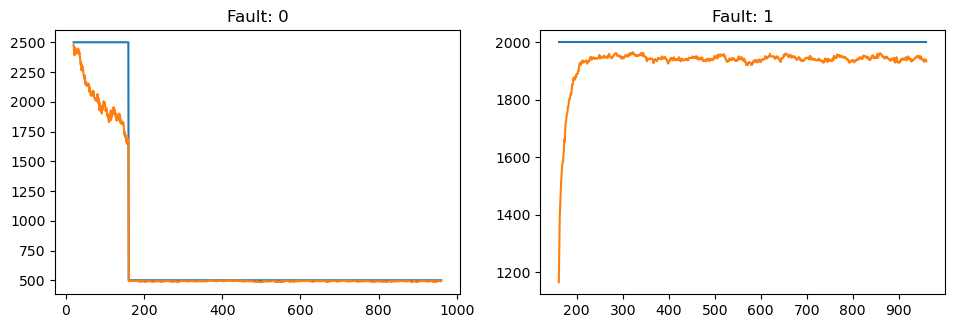

In [11]:
results_ratio_dict = {}
plt.figure(figsize=(24, 24))

for fault in results_df['Actual'].unique():
    # Set up a subplot for each fault
    plt.subplot(6, 4, fault + 1)
    
    # Aggregate counts of 'Actual' by sample for samples less than 401
    one_one = results_df[(results_df['Actual'] == fault)].groupby('sample').count()
    plt.plot(one_one['Actual'])

    # Sum 'Correct' by sample for samples less than 401
    tne_one = results_df[(results_df['Actual'] == fault)].groupby('sample').sum()
    plt.plot(tne_one['Correct'])
    
    plt.title(f'Fault: {fault}')

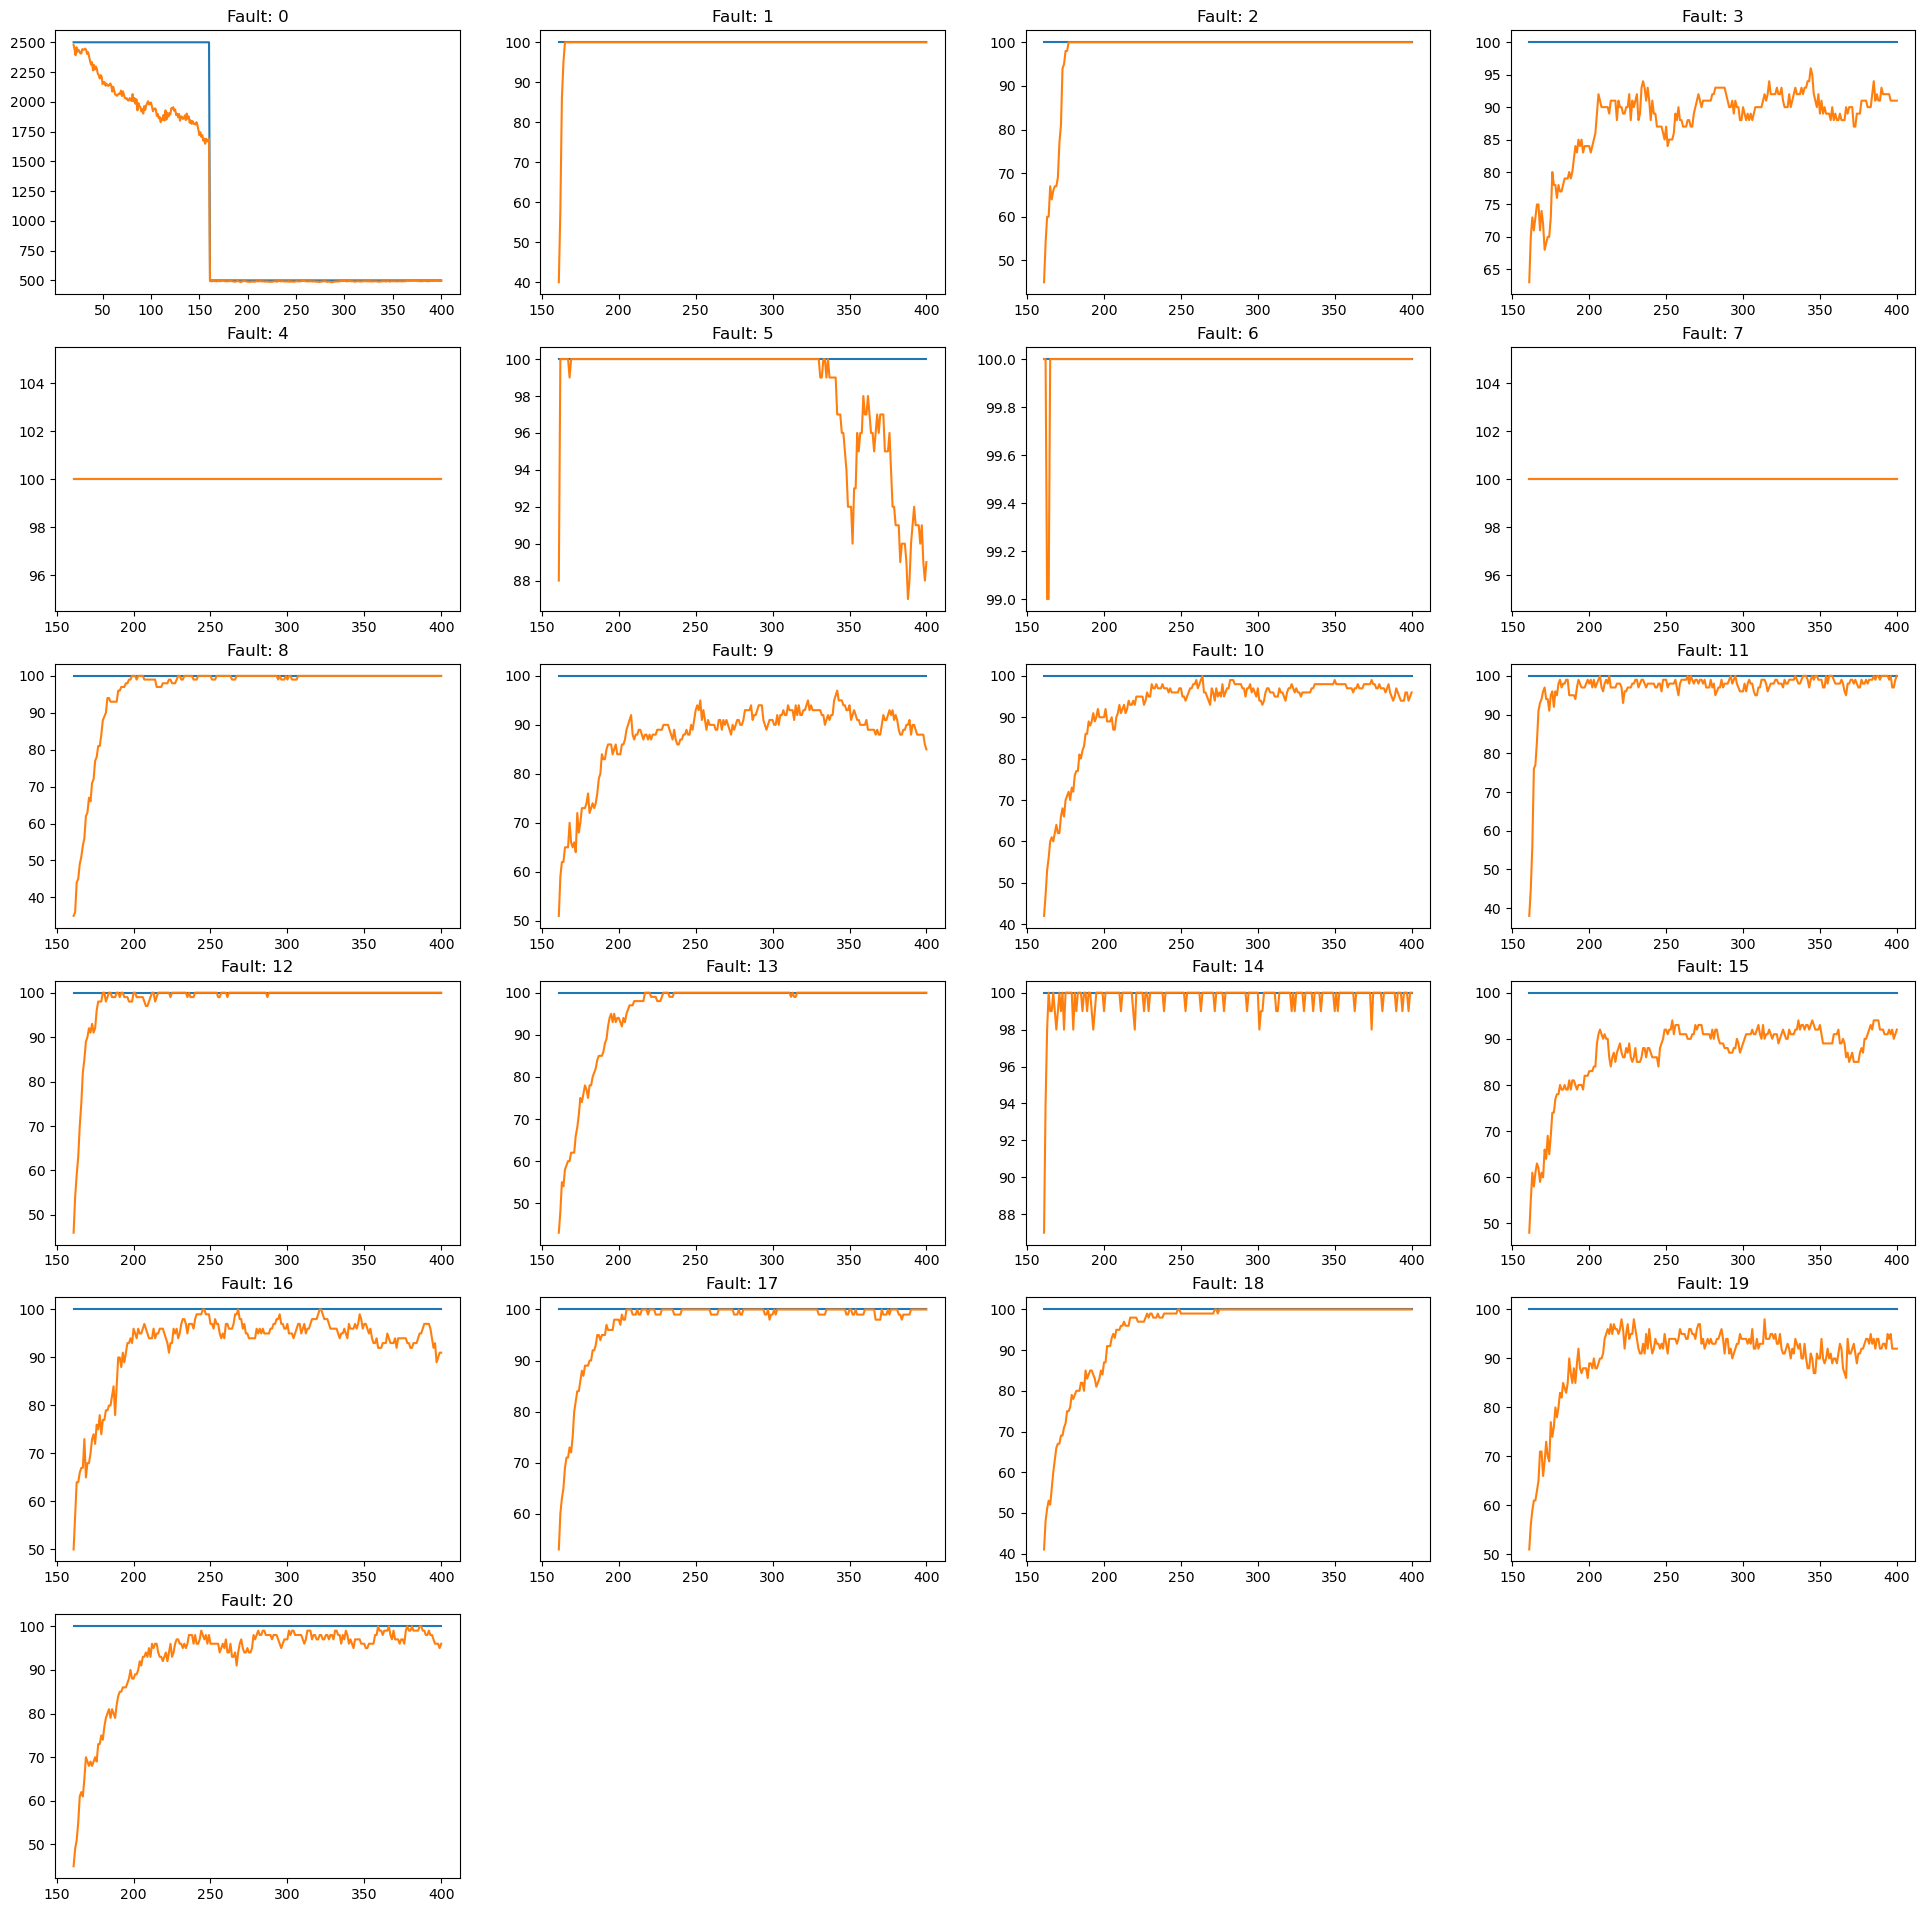

In [12]:
results_ratio_dict = {}
plt.figure(figsize=(24, 24))

# Loop through each unique fault type in the results DataFrame
for fault in results_df['faultNumber'].unique():
    
    plt.subplot(6, 4, fault + 1) 
    
    # Count entries per sample for each fault type with samples less than 401
    count_per_sample = results_df.loc[(results_df['faultNumber'] == fault) & (results_df['sample'] < 401)].groupby('sample').count()
    plt.plot(count_per_sample['Actual'])  # Plot the counts of 'Actual'
    
    # Sum 'Correct' per sample for each fault type with samples less than 401
    sum_per_sample = results_df.loc[(results_df['faultNumber'] == fault) & (results_df['sample'] < 401)].groupby('sample').sum()
    plt.plot(sum_per_sample['Correct'])  # Plot the sums of 'Correct'
    plt.title(f'Fault: {fault}')  # Title the plot with the fault type

## Multiclassification (LSTM)

The second part of the challenge to accurately predict and classify faults in the TEP process is to classify the **type** of fault (which was previously correctly predicted by the Random Forest model) occuring. There are 20 faults possible - more details are available in the EDA file.

The first step is to re-trace the predicted rows to the original data frame and extra those values to use as the test set for the LSTM model.

In [20]:
# Filter the indices where the 'Predicted' column has a value of 1
indices_predicted_1 = results_df.index[results_df['Predicted'] == 1]

# Extract rows from the combined_df_test DataFrame using the filtered indices
lstm_test = combined_df_test.loc[indices_predicted_1]

# Display the extracted rows
lstm_test.head()

,faultNumber,faultOccurrence,original_faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
21,0,0,1,1,22,0.29755,3698.0,4514.7,9.3022,26.597,...,53.019,29.071,59.672,20.980,42.445,45.621,46.170,47.600,40.505,19.483
128,0,0,1,1,129,0.21702,3685.9,4460.0,9.2655,27.004,...,54.643,20.784,62.023,21.880,42.047,39.894,45.595,44.708,40.677,15.438
129,0,0,1,1,130,0.21455,3694.8,4486.1,9.2569,26.767,...,54.331,21.027,61.383,21.641,41.959,42.834,43.625,44.620,41.146,18.744
130,0,0,1,1,131,0.17615,3646.5,4508.7,9.2932,27.603,...,53.921,17.308,60.905,21.869,40.351,34.310,44.120,44.621,39.707,16.282
131,0,0,1,1,132,0.17617,3640.2,4511.1,9.3407,27.132,...,53.892,17.307,60.754,21.366,40.604,38.945,43.343,44.498,41.081,18.996


Next, the original data frames are used for splitting into necessary train and cross validation sets for the LSTM model. Sliding window is incorporated as a necessary technique for proper function of the LSTM model.

In [21]:
# Splitting the dataset into train, cross-validation and test sets
lstm_train = combined_df.drop(columns=['faultOccurrence', 'simulationRun', 'sample', 'original_faultNumber'])
train, cv = train_test_split(lstm_train, test_size=0.2, shuffle=False, random_state=42)
test = lstm_test.drop(columns=['faultOccurrence', 'simulationRun', 'sample', 'original_faultNumber'])

train.head()

,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [28]:
def SlidingWindow(df, w, s):
    '''
    Create sliding windows of fixed size from the dataframe for sequence prediction tasks.

    Parameters:
    - df: DataFrame containing the sequential data.
    - w: Size of the sliding window.
    - s: Step size or stride of the sliding window.

    Returns:
    - X: Array of input sequences, each of size (w, n), where n is the number of features.
    - Y: Array of corresponding target values.
    '''
    
    X = []
    Y = []
    
    # Find the index of the first column (target variable)
    target_index = 0
    
    for i in range(0, len(df)-w+1, s):
        # Selecting features from the columns after the first column
        x = np.array(df.iloc[i:i+w, 1:])  # Exclude the first column
        
        # Selecting the target value from the first column
        y = df.iloc[i, target_index] 
        
        X.append(x)
        Y.append(y)
        
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

def process_data(train, test, cv, SlidingWindow):
    '''
    Process the training, testing, and cross-validation data by extracting sliding windows for sequence prediction tasks.

    Parameters:
    - train: DataFrame containing the training data.
    - test: DataFrame containing the testing data.
    - cv: DataFrame containing the cross-validation data.
    - SlidingWindow: Function to create sliding windows from sequential data.

    Returns:
    - X_train: Array of input sequences for training.
    - Y_train: Array of corresponding target values for training.
    - X_test: Array of input sequences for testing.
    - Y_test: Array of corresponding target values for testing.
    - X_cv: Array of input sequences for cross-validation.
    - Y_cv: Array of corresponding target values for cross-validation.
    '''
    
    # Initialize window size and step size
    w = 20
    s = 20

    # Initialize lists for storing the data
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    X_cv = []
    Y_cv = []

    # Extract sliding windows for training data
    x_train_temp, y_train_temp = SlidingWindow(train, w, s)
    X_train.extend(x_train_temp)
    Y_train.extend(y_train_temp)

    # Extract sliding windows for testing data
    x_test_temp, y_test_temp = SlidingWindow(test, w, s)
    X_test.extend(x_test_temp)
    Y_test.extend(y_test_temp)

    # Extract sliding windows for cross-validation data
    x_cv_temp, y_cv_temp = SlidingWindow(cv, w, s)
    X_cv.extend(x_cv_temp)
    Y_cv.extend(y_cv_temp)

    # Convert X and Y to numpy arrays and reshape X for LSTM
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = X_train.reshape(-1, w, X_train.shape[-1])

    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_test = X_test.reshape(-1, w, X_test.shape[-1])

    X_cv = np.array(X_cv)
    Y_cv = np.array(Y_cv)
    X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

    return X_train, Y_train, X_test, Y_test, X_cv, Y_cv

# Call the function to process the data
X_train, Y_train, X_test, Y_test, X_cv, Y_cv = process_data(train, test, cv, SlidingWindow)

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)
print("Shape of X_cv:", X_cv.shape)
print("Shape of Y_cv:", Y_cv.shape)

The pipeline involves standardization and onehot coding of the target variable (faultNumber) in preparation for use in the model.

In [182]:
sc = StandardScaler()
sc.fit(train.iloc[:, 1:])

# Transform the datasets using the fitted StandardScaler
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y_train
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values to one-hot encoded form for train, test, and cross-validation sets
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))
Y_test_enc = enc.transform(Y_test.reshape(-1, 1))
Y_cv_enc = enc.transform(Y_cv.reshape(-1, 1))

c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The LSTM model includes dropout, early stopping and ...

In [183]:
# Create Precision and Recall instances
precision_metric = Precision()
recall_metric = Recall()

def f1_score(y_true, y_pred):
    """Calculate F1 score"""
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def LSTM_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128, activation="tanh", return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)

    # Compile LSTM model with F1 score as the metric
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_score])
    
    return lstm_model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 52)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          185344    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 21)                6321      
                                                             

KeyError: 'accuracy'

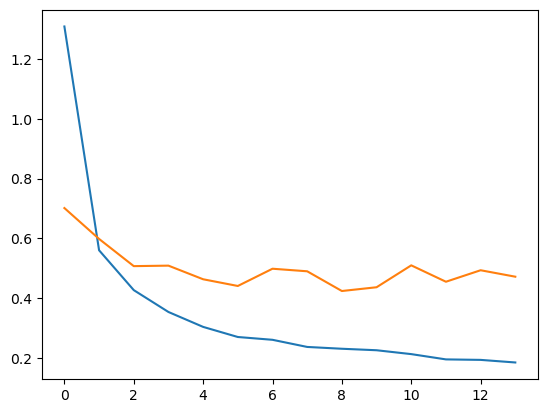

In [184]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 200 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and F1 score
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

A classification report is generated showcasing accuracy for different types of faults predicted.

In [185]:
### ONLY FOR LOADING PRE-TRAINED MODEL

pkl_url = 'https://drive.google.com/file/d/1uXleGKhuwpMwUDOyL_hvKRLzKv_pWaqd/view?usp=sharing'

# Download the .pkl file
file_id = pkl_url.split('/')[-2].split('=')[-1]
url_direct = f'https://drive.google.com/uc?id={file_id}'
output_path = 'LSTM_model.pkl'  # Specify the desired name for the downloaded file
gdown.download(url_direct, output_path, quiet=False)

# Load the .pkl file into your notebook
with open(output_path, 'rb') as f:
    LSTM_model = pickle.load(f)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.05      0.08      5779
           1       0.95      0.97      0.96      2090
           2       0.96      0.97      0.96      2323
           3       0.48      0.81      0.60      1978
           4       0.96      0.99      0.98      2000
           5       0.97      0.98      0.97      2277
           6       0.96      0.98      0.97      2139
           7       0.97      0.99      0.98      2207
           8       0.90      0.97      0.93      2321
           9       0.29      0.23      0.26      1886
          10       0.79      0.91      0.85      2460
          11       0.85      0.97      0.91      2345
          12       0.94      0.96      0.95      2208
          13       0.80      0.96      0.87      2357
          14       0.98      0.98      0.98      2277
          15       0.36      0.68      0.47      2138
          16       0.73      0.93      0.82      2161
    

In [ ]:
# Obtain predictions and true labels
y_pred = enc.inverse_transform(model.predict(X_test_sc, verbose=0))
y_true = enc.inverse_transform(Y_test_enc)

In [ ]:
### ONLY FOR SAVING MODEL FILE
model_pkl_file = "rf_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(LSTM_model, file)

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score:", accuracy_score(y_true, y_pred))